# Notebook 5 : Réalisation d'un benchmark des méthodes calcul de distance

L'objectif de ce notebook est de réaliser un benchmark pour tester plusieurs méthodes de distances afin de déterminer laquelle utiliser.

Nous allons tester les méthodes suivantes :
- Distance euclidienne
- Similarité cosinus
- Produit scalaire

## Étape 1 : Création des méthodes de calcul de distance

In [1]:
import numpy as np

def euclidian_distance(v1: np.ndarray, v2: np.ndarray):
    return np.linalg.norm(v1 - v2)

def cosine_similarity(v1: np.ndarray, v2: np.ndarray):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

def dot_product(v1: np.ndarray, v2: np.ndarray):
    return np.dot(v1, v2)

## Étape 2 : Lancement du calculs de distance

In [ ]:
import pandas as pd
import sqlite3

conn = sqlite3.connect('../data/database.db')
query = 'SELECT * FROM cocktails'
cocktails_df = pd.read_sql_query(query, conn)

cocktails_df['vector_decode'] = cocktails_df['vector'].apply(lambda x: np.frombuffer(x, dtype=np.float32))

In [3]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

def get_embedding(text):
    return model.encode(text)

C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def get_closest_cocktails(input: str, distance_metric: str):
    input_vector = get_embedding(input)
    cocktails_df[input] = cocktails_df['vector_decode'].apply(lambda x: distance_metric(input_vector, x))
    return cocktails_df.sort_values(by=input).head(10)['name'].tolist()

In [5]:
questions_df = pd.read_csv('cocktails_questions_eval.csv')
questions_df['relevant_cocktails_decode'] = questions_df['relevant_cocktails'].apply(lambda x: x.split('; '))

questions_df['euclidian_distance'] = questions_df['question'].apply(lambda x: get_closest_cocktails(x, euclidian_distance))
questions_df['cosine_similarity'] = questions_df['question'].apply(lambda x: get_closest_cocktails(x, cosine_similarity))
questions_df['dot_product'] = questions_df['question'].apply(lambda x: get_closest_cocktails(x, dot_product))

## Étape 3 : Création des méthodes d'évaluation

Comme méthodes d'évaluation, nous allons utiliser :
- First_relevant : pour déterminer a quoi point la méthode de distance est capable de trouver le premier élément de la liste des plus proches voisins
- Precision_at_k (p@k): pour déterminer la précision de la méthode de distance pour les k premiers éléments de la liste des plus proches voisins (ici nous allons prendre k = 5 et k = 10)
- Normalize Discounted cumulative gain (NDCG) : pour déterminer la pertinence des éléments de la liste des plus proches voisins (plus d'info sur [ce lien](https://en.wikipedia.org/wiki/Discounted_cumulative_gain))

In [6]:
def first_relevant(true, pred):
    for i in range(len(pred)):
        if pred[i] == true[0]:
            return 1/(i+1)
    return 0.0

def precision_at_k(true, pred, k):
    relevant_docs = set(true)
    pred_relevant = [doc in relevant_docs for doc in pred[:k]]
    return sum(pred_relevant) / k

def ndcg(true, pred):
    def dcg(relevances):
        dcg = 0.0
        for i in range(len(relevances)):
            dcg += (2 ** relevances[i] - 1) / np.log2(i + 2)
        return dcg

    true_relevances = [1 if doc in true else 0 for doc in pred]
    ideal_relevances = sorted(true_relevances, reverse=True)
    if dcg(ideal_relevances) == 0:
        return 0.0
    else:
        return dcg(true_relevances) / dcg(ideal_relevances)

## Étape 4 : Calcul des performances des méthodes

In [7]:
questions_df['first_relevant_euclidian'] = questions_df.apply(lambda x: first_relevant(x['relevant_cocktails_decode'], x['euclidian_distance']), axis=1)
questions_df['first_relevant_cosine'] = questions_df.apply(lambda x: first_relevant(x['relevant_cocktails_decode'], x['cosine_similarity']), axis=1)
questions_df['first_relevant_dot'] = questions_df.apply(lambda x: first_relevant(x['relevant_cocktails_decode'], x['dot_product']), axis=1)

questions_df['precision_at_5_euclidian'] = questions_df.apply(lambda x: precision_at_k(x['relevant_cocktails_decode'], x['euclidian_distance'], 5), axis=1)
questions_df['precision_at_5_cosine'] = questions_df.apply(lambda x: precision_at_k(x['relevant_cocktails_decode'], x['cosine_similarity'], 5), axis=1)
questions_df['precision_at_5_dot'] = questions_df.apply(lambda x: precision_at_k(x['relevant_cocktails_decode'], x['dot_product'], 5), axis=1)

questions_df['precision_at_10_euclidian'] = questions_df.apply(lambda x: precision_at_k(x['relevant_cocktails_decode'], x['euclidian_distance'], 10), axis=1)
questions_df['precision_at_10_cosine'] = questions_df.apply(lambda x: precision_at_k(x['relevant_cocktails_decode'], x['cosine_similarity'], 10), axis=1)
questions_df['precision_at_10_dot'] = questions_df.apply(lambda x: precision_at_k(x['relevant_cocktails_decode'], x['dot_product'], 10), axis=1)

questions_df['ndcg_euclidian'] = questions_df.apply(lambda x: ndcg(x['relevant_cocktails_decode'], x['euclidian_distance']), axis=1)
questions_df['ndcg_cosine'] = questions_df.apply(lambda x: ndcg(x['relevant_cocktails_decode'], x['cosine_similarity']), axis=1)
questions_df['ndcg_dot'] = questions_df.apply(lambda x: ndcg(x['relevant_cocktails_decode'], x['dot_product']), axis=1)

## Étape 5 : Visualisations

C:\Users\nicol\AppData\Local\Temp\ipykernel_5748\78908639.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_avg = questions_df.groupby("category").mean()


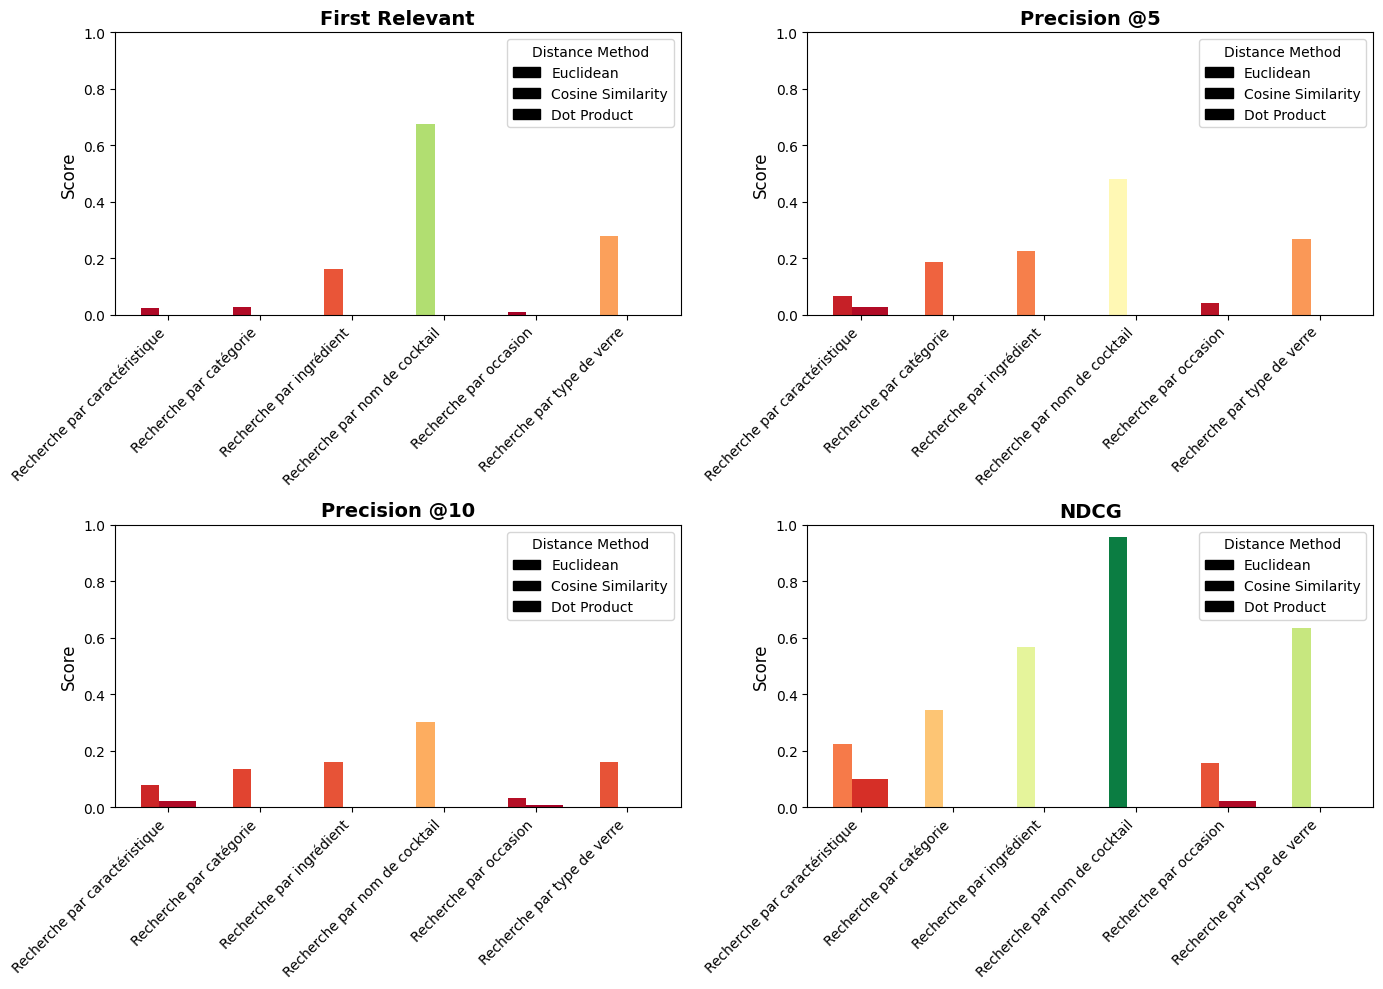

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

df_avg = questions_df.groupby("category").mean()

metric_groups = {
    "First Relevant": ["first_relevant_euclidian", "first_relevant_cosine", "first_relevant_dot"],
    "Precision @5": ["precision_at_5_euclidian", "precision_at_5_cosine", "precision_at_5_dot"],
    "Precision @10": ["precision_at_10_euclidian", "precision_at_10_cosine", "precision_at_10_dot"],
    "NDCG": ["ndcg_euclidian", "ndcg_cosine", "ndcg_dot"]
}

bar_width = 0.2
space_between_categories = 0.4

categories = df_avg.index.tolist()
num_categories = len(categories)

norm = mcolors.Normalize(vmin=0, vmax=1)
cmap = cm.RdYlGn 

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten() 

distance_methods = ["Euclidean", "Cosine Similarity", "Dot Product"]

for ax, (metric_name, metric_columns) in zip(axes, metric_groups.items()):
    x = np.arange(num_categories)

    for i, metric in enumerate(metric_columns):
        values = df_avg[metric]
        colors = [cmap(norm(v)) for v in values] 
        ax.bar(x + i * bar_width, values, width=bar_width, color=colors, label=metric.split("_")[-1])

    ax.set_xticks(x + bar_width)
    ax.set_xticklabels(categories, rotation=45, ha="right", fontsize=10)
    ax.set_title(metric_name, fontsize=14, fontweight="bold")
    ax.set_ylabel("Score", fontsize=12)
    ax.set_ylim(0, 1)
    legend_patches = [Patch(color="black", label=distance_methods[j]) for j in range(3)]
    ax.legend(handles=legend_patches, title="Distance Method")

plt.tight_layout()
plt.show()

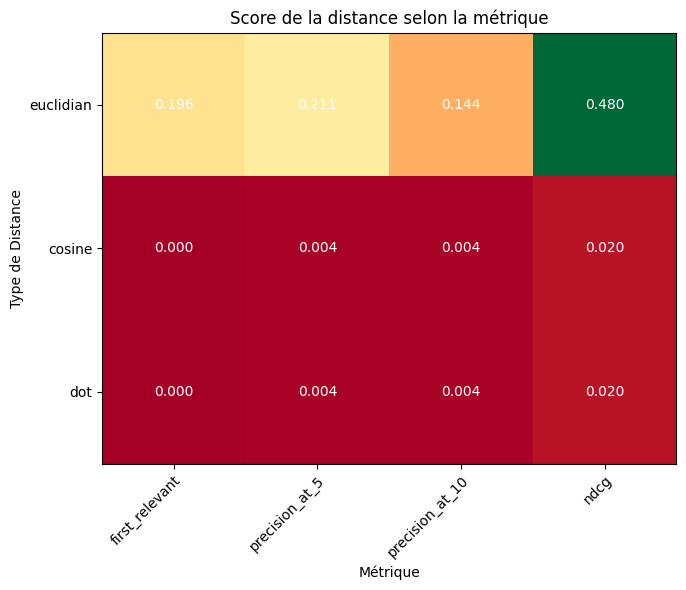

In [10]:
import matplotlib.pyplot as plt
import numpy as np

distance_methods = ["euclidian", "cosine", "dot"]
metrics = ["first_relevant", "precision_at_5", "precision_at_10", "ndcg"]

data = np.array([[questions_df[f'{metric}_{distance}'].mean() for metric in metrics] for distance in distance_methods])

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(data, cmap="RdYlGn")

ax.set_yticks(np.arange(len(distance_methods)), labels=distance_methods)
ax.set_xticks(np.arange(len(metrics)), labels=metrics)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(len(metrics)):
    for j in range(len(distance_methods)):
        text = ax.text(i, j, f"{data[j, i]:.3f}", ha="center", va="center", color="w")

ax.set_title("Score de la distance selon la métrique")
ax.set_xlabel("Métrique")
ax.set_ylabel("Type de Distance")
fig.tight_layout()
plt.show()

## Étape 6 : Analyse et Conclusion

On voit très clairement que les méthodes Cosinus Similarity et Dot Product sont très mauvaises, nous allons donc garder la distance Euclidienne.

De plus, nous pouvons remarquer que la catégorie 'Recherche par nom de cocktail' marche mieux que les autres catégories, ce qui est logique puisqu'ils sont un élément clé dans la recherche vectorielle.